## Demo 6 - movie poster classification

Multi-label (meaning that there is more than one "true" label) classification of movie poster images by genre.

In [1]:
import os
import sys
from skimage import io
from torch import nn
import torch
import numpy as np
import pandas as pd

### Load the data

I have left this part mostly (if not totally) unchanged. The data loading part does not require any modifications.

In [2]:
from torch.utils.data import Dataset
from skimage import transform
from skimage import color

class MoviePosterDataset(Dataset):
    def __init__(self, csvfile, imagedir, device="cpu"):
        self.posterlist = pd.read_csv(csvfile)
        self.imagedir = imagedir
        
        imageids = list(self.posterlist["Id"])
        imagefiles = ["{}/{}.jpg".format(self.imagedir, x) for x in imageids]
        images = [np.array(io.imread(x)) for x in imagefiles]
        images = np.array([color.gray2rgb(x) if len(x.shape) < 3 else x for x in images])
        
        truths = self.posterlist[self.posterlist.columns[2:]]
        self.truths = torch.Tensor(truths.to_numpy())
    
        tns = torch.from_numpy(images)
        self.images = tns.permute(0, 3, 1, 2)
        
        if device != "cpu":
            self.device = torch.device(device)
            self.images = self.images.to(self.device)
            self.truths = self.truths.to(self.device)
        
    def __len__(self):
        return len(self.posterlist)
    
    def __getitem__(self, idx):            
        truths = self.truths[idx]
        images = self.images[idx]
        
        return images, truths

I changed the paths here, and specified the path to the training file and the dataset of images as it is on the server. I did not load anything on the GPU as I want to use that only while training.

In [3]:
mpd = MoviePosterDataset("/usr/local/courses/lt2316-h19/Multi_Label_dataset/train.csv", 
                         "/usr/local/courses/lt2316-h19/Multi_Label_dataset/ImageSmaller", device="cpu")
mpd.images.shape, mpd.truths.shape

(torch.Size([7254, 3, 300, 450]), torch.Size([7254, 25]))

### Define the model

I spent a lot of time on this model, experimenting with different layers and network architecture elements. The code looks quite messy here, but I did not clean it up because I wanted the commented out code to reflect the various things I tried out before eventually deciding upon said architecture. To make it more readable and understandable, here is the final network architecture that I'm using:

- A 2d convolutional layer with 3 input channels (this is the input image), 16 output channels, a filter size of 5, a stride of 1 and padding of 2. I used this particular configuration (especially the padding value) so that the resultant image after applying the convolution remains of the same dimensions.
- Batch Normalization
- Activation function ReLU
- Maxpooling with filter size 2 and stride of 2. This reduces the image dimensions to (150, 225).


- A 2d convolutional layer with 16 input channels (from the previous convolution), 32 output channels, a filter size of 5, a stride of 1 and padding of (2,3). 
- Dropout of 0.2
- Batch Normalization
- Activation function ReLU
- Maxpooling with filter size 2 and stride of 2. This reduces the image dimensions to (75, 112).


- A 2d convolutional layer with 32 input channels (from the previous convolution), 64 output channels, a filter size of 5, a stride of 1 and padding of (3,2). 
- Dropout of 0.2
- Batch Normalization
- Activation function ReLU
- Maxpooling with filter size 2 and stride of 2. This reduces the image dimensions to (37, 56).


- A linear layer which reshapes the output from 64\*37\*56 to 3000 data points.
- A dropout of 0.2
- Activation function ReLU


- A linear layer which reshapes the output from 3000 to 25 data points.
- Dropout of 0.2
- Activation function Sigmoid.

#### Experiments with the model

I noticed that having only one convolutional layer doesn't do much - the model does not really learn anything. Adding two didn't help much either - it was with 3 convolutional layers that the training loss started going down consistently. Having a fourth convolutional layer helps even more, and the model converges faster - however, this fourth convolutional layer also makes the model overfit more.

And this is indeed the more troubling issue that I've faced with this task - the loss on the validation loss goes down in the start, but then just starts fluctuating around a fixed value. Moreover, if the number of epochs is high, the validation loss eventually starts increasing, which I think indicates that the model is overfitting. Because of this, I removed the fourth convolutional layer.

I also had another linear layer, between the final two linear layers, but I removed it for the same reason - the model was overfitting on the data. 

For dealing with overfitting, I found that batch normalization helped a lot, as it normalizes the data between the layers. I added dropouts too, but I found they do not help as much - and if I add a large value for the dropout, the model stops learning at all - which makes sense I suppose.

The output channels I initially had were 5, 10, 15... but later I realized that the convention is to use output channels of values to the power of 2. So then I started with 16, then went to 32 and 64.

In [4]:
class PosterClassifier(nn.Module):
    def __init__(self, d1, d2, dropout=0.2):
        super().__init__()
        in_channels = 3
#         self.out_channels = 5
        filter_size = 5
        padding = 2
        stride = 1
        
        self.conv1 = nn.Conv2d(3, 16, filter_size, stride=stride, padding=padding)
#         self.dropout1 = nn.Dropout(dropout)
        self.bnm1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, filter_size, stride=stride, padding=padding)
        self.dropout2 = nn.Dropout(dropout)
        self.bnm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d((2,3), stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, filter_size, stride=stride, padding=padding)
        self.dropout3 = nn.Dropout(dropout)
        self.bnm3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d((3,2), stride=2)
        
#         self.conv4 = nn.Conv2d(64, 128, filter_size, stride=stride, padding=padding)
#         self.dropout4 = nn.Dropout(dropout)
#         self.bnm4 = nn.BatchNorm2d(128)
#         self.maxpool4 = nn.MaxPool2d((3,2), stride=2)
        
#         self.conv2d1 = nn.Conv2d(in_channels, self.out_channels, filter_size, stride=stride, padding=padding)
#         self.dropout1 = nn.Dropout(dropout)
#         self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
#         self.conv2d2 = nn.Conv2d(self.out_channels, 10, filter_size, stride=stride, padding=padding)
#         self.dropout2 = nn.Dropout(dropout)
#         self.maxpool2 = nn.MaxPool2d((2,3), stride=2)
        
#         self.conv2d3 = nn.Conv2d(10, 32, filter_size, stride=stride, padding=padding)
#         self.dropout3 = nn.Dropout(dropout)
#         self.maxpool3 = nn.MaxPool2d((3,2), stride=2)
        
        self.linear0 = nn.Linear(64 * 37 * 56, 3000)
#         self.linear0 = nn.Linear(128 * 18 * 28, 3000)
        self.dropout4 = nn.Dropout(dropout)
        
#         self.linear1 = nn.Linear(3000, 1500)
#         self.dropout5 = nn.Dropout(dropout)
        
        self.linear2 = nn.Linear(3000, 25)
        self.dropout6 = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        output = self.conv1(x)
        output = self.bnm1(output)
#         output = self.dropout1(output)
        output = nn.functional.relu(output)
        output = self.maxpool1(output)
        
        output = self.conv2(output)
        output = self.dropout2(output)
        output = self.bnm2(output)
        output = nn.functional.relu(output)
        output = self.maxpool2(output)
        
        output = self.conv3(output)
        output = self.bnm3(output)
        output = self.dropout3(output)
        output = nn.functional.relu(output)
        output = self.maxpool3(output)
        
#         output = self.conv4(output)
#         output = self.bnm4(output)
#         output = self.dropout4(output)
#         output = nn.functional.relu(output)
#         output = self.maxpool4(output)
        
        output = output.view(-1, 64 * 37 * 56)
#         output = output.view(-1, 128 * 18 * 28)
        output = self.linear0(output)
        output = self.dropout4(output)
        output = nn.functional.relu(output)
        
#         output = self.linear1(output)
#         output = self.dropout5(output)
#         output = nn.functional.relu(output)
        
        output = self.linear2(output)
        output = self.dropout6(output)
        output = self.sigmoid(output)
        
        return output

### Arrange the data for the model

This part originally had a 60/40 split for training and testing data. I have replaced this with a 60/20/20 split for training, validation and testing data.

In [5]:
import random
import math

totalindices = list(range(len(mpd)))
random.shuffle(totalindices)
train_test_split_index = math.floor(len(mpd)*0.8)

In [6]:
train_test_split_index

5803

In [7]:
train_val_indices = totalindices[:train_test_split_index]
test_indices = totalindices[train_test_split_index:]

In [8]:
train_val_split_index = math.floor(len(train_val_indices)*0.8)
train_indices = train_val_indices[:train_val_split_index]
val_indices = train_val_indices[train_val_split_index:]

In [9]:
len(train_indices), len(val_indices), len(test_indices)

(4642, 1161, 1451)

In [10]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

The batch size defined here is currently 32. I experimented with sized 16 and 32 during my work with the model and training. I originally wanted to have a batch size of 64, but that causes memory issues with the GPU, so I had to stick to either 16 or 32.

In [11]:
batch_size = 32
traindl = torch.utils.data.DataLoader(mpd, batch_size=batch_size, 
                                      sampler=train_sampler, pin_memory=False)
valdl = torch.utils.data.DataLoader(mpd, batch_size=batch_size, sampler=val_sampler, pin_memory=False)
testdl = torch.utils.data.DataLoader(mpd, sampler=test_sampler)

### Write and run the training loop

In the training loop here, I used the GPU "cuda:1", which is the GPU assigned to me as per my username. I used the Adam optimizer, with a learning rate of 0.0001 (as I found that the model starts oscillating around some value and doesn't converge if I use a higher learning rate), and added a weight decay of 1e-5 for some regularization. Most of the other configuration is kept the same.

The major thing added here is the fact that in each epoch, I first set the model to train mode and train over all batches in the training dataloader. Then I set the model to eval mode, and test it over all batches in the validation dataloader. I calculate the total loss after both, and I maintain a list of train loss and validation loss after each epoch for plotting purposes later.

I have set the number of epochs to 15 here because I found that if the model is trained over more epochs (like 30, as in the original example), the validation loss starts increasing, which means the model is overfitting. Since the model architecture is quite complex and overfitting can happen quickly, I found it best to limit the number of epochs to 10 or 15.

In [12]:
def calculate_jaccard_index(y_true, pred):
    intersection = 0
    union = 0
    for i in range(len(y_true)):
        if y_true[i] == pred[i]:
            intersection += 1
        union += 1
    j_index = float(intersection)/float(union)
    return j_index

In [13]:
import torch.optim as optim

def train(train_dataloader, val_dataloader, epochs=3):
    dev = "cuda:1"
    torch.cuda.empty_cache()
    model = PosterClassifier(d1=450, d2=300)
    model = model.to(dev)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    criterion = nn.BCELoss()
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        sum_train_loss = 0
        sum_val_loss = 0
        total_batches = 0
        model.train()
        for c, data in enumerate(train_dataloader):
            images, truth = data
            optimizer.zero_grad()
            images = images.float().to(dev)
            truth = truth.to(dev)
            output = model(images)
            loss = criterion(output, truth)
            sum_train_loss += loss.item()
            total_batches += 1.0
            loss.backward()
            optimizer.step()

        total_loss = sum_train_loss/total_batches
        train_losses.append(total_loss)
        print("In epoch {}, training loss = {}".format(epoch, total_loss))
        
        total_batches = 0
        model.eval()
        jaccard_indices = []
        for c, data in enumerate(val_dataloader):
            images, truth = data
            images = images.float().to(dev)
            truth = truth.to(dev)
            output = model(images)
            with torch.no_grad():
                loss = criterion(output, truth)            
            sum_val_loss += loss.item()
            total_batches += 1.0
            
            truth = truth.to("cpu")
            output = output.to("cpu")
            
            for i in range(len(truth)):
                pred = [a.item() for a in truth[i]]
                o = [a.item() for a in output[i]]
                o = [1.0 if a > 0.5 else 0.0 for a in o]
                ji = calculate_jaccard_index(pred, o)
                jaccard_indices.append(ji)
#             print(jaccard_indices)
            
        total_loss = sum_val_loss/total_batches
        val_losses.append(total_loss)
        average_ji = float(sum(jaccard_indices))/float((batch_size*total_batches))
        print("In epoch {}, validation loss = {}".format(epoch, total_loss))
        print("In epoch {}, average jaccard index = {}".format(epoch, average_ji))
        print()

    return model, train_losses, val_losses

In [14]:
# model = PosterClassifier(d1=450, d2=300)
# dev = "cuda:1"
# model = model.to(dev)
# for data in traindl:
#     images, truth = data
#     images = images.float().to(dev)
#     output = model(images)
#     break
model, train_losses, val_losses = train(traindl, valdl, epochs=15)

In epoch 0, training loss = 2.093218746658874
In epoch 0, validation loss = 0.7304236099526689
In epoch 0, average jaccard index = 0.8823310810810785

In epoch 1, training loss = 0.8008902307650815
In epoch 1, validation loss = 0.32049158255796173
In epoch 1, average jaccard index = 0.8845270270270245

In epoch 2, training loss = 0.4188594299636475
In epoch 2, validation loss = 0.24316257439755104
In epoch 2, average jaccard index = 0.8924324324324299

In epoch 3, training loss = 0.3365693133171291
In epoch 3, validation loss = 0.2409886907081346
In epoch 3, average jaccard index = 0.894662162162162

In epoch 4, training loss = 0.3285357866385212
In epoch 4, validation loss = 0.24795932222057032
In epoch 4, average jaccard index = 0.8931418918918897

In epoch 5, training loss = 0.3270398364083408
In epoch 5, validation loss = 0.24160421498723933
In epoch 5, average jaccard index = 0.8929054054054016

In epoch 6, training loss = 0.32219712579087034
In epoch 6, validation loss = 0.248102

In [15]:
# actual = [a.item() for a in truth[0]]
# pred = [a.item() for a in output[0]]
# pred = [1.0 if a > 0.5 else 0.0 for a in pred]
# calculate_jaccard_index(actual, pred)

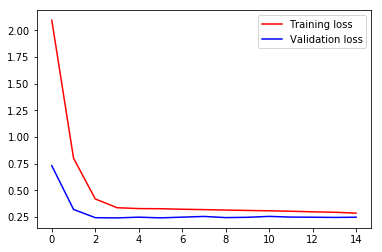

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, 'r')
plt.plot(val_losses, 'b')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

I briefly played around with the idea of data augmentation and image normalization for this problem, which could have potentially helped a lot, but since the task was to improve the loss by modifying the network architecture only, I didn't do that.

Another way to solve this problem could have been to use a pre-trained model on this problem, if one is available - kind of like how we used BERT for sequence classification in Assignment 2.

### Write and run a testing routine

Most of the code is kept same here. The loss on the testing data was 1.03 in the original example, so this loss of ~0.24 on the test set through the updated model shows that it has underwent a great improvement. However, I wanted to evaluate it through another metric like accuracy, but found that this doesn't work too well when our output is a one-hot vector. Accuracy seems like too harsh a metric, if we use like how I tried to - but perhaps there are better ways to evaluate a multi-label classification problem than accuracy.

In [17]:
def test(model, dataloader):
    model = model.to("cpu")
    model.eval()
    criterion = nn.BCELoss()
    sumloss = 0
    items = 0
    total_predictions = 0
    accurate_predictions = 0
    jaccard_indices = []
    for c, data in enumerate(testdl):
        images, truth = data
        output = model(images.float())
        loss = criterion(output, truth)
        sumloss += loss
        items += 1.0

        o = output > 0.8
        o = (o.float() == truth)[0]
        values = list(set([x.item() for x in o]))
        if len(values) == 1 and values[0] is True:
            accurate_predictions += 1
        total_predictions += 1
        
        pred = [a.item() for a in output[0]]
        pred = [1.0 if a > 0.5 else 0.0 for a in pred]
        actual = [a.item() for a in truth[0]]
        j_index = calculate_jaccard_index(actual, pred)
        jaccard_indices.append(j_index)

    print("Loss on test data = {}".format(sumloss/items))
    print("Accuracy on test data = {}".format(accurate_predictions/total_predictions))
    print("Jaccard index on test data = {}".format(sum(jaccard_indices)/total_predictions))

In [18]:
test(model, testdl)

Loss on test data = 0.24928903579711914
Accuracy on test data = 0.005513439007580979
Jaccard index on test data = 0.9101860785665119


Perhaps another way to use the accuracy metric on this problem is to consider all labels individually? So the accuracy would not be predicted over whether the whole output vector was correct or not, but which elements inside each output vector were predicted accurately. However, that still leaves the problem of the threshold to use when figuring out whether a certain element in the output vector is 1 or 0. Perhaps we can experiment with threshold values using the ROC curve? I'm not sure if that applies here or not.

## Final Note

I found this quite an interesting problem, and a good introduction into working with image data, instead of text data as we usually have. I would have liked to try a bunch of other things, since I'm sure there a lot of things we can do with neural networks and image data - however, I do not know much about them (yet!) as we have mostly dealt with text data in this course. 

I don't quite know why the model performs so poorly; based on the validation loss and the performance on the test data, it seems like the model either doesn't learn much, or it massively overfits in the start. Perhaps it could also be a data quantity issue - ~6000 instances for colored images multi-label classification might not be enough for good results.

Also, perhaps the Jaccard similarity might have been a better evaluation metric for this model rather than the Jaccard Index? Since the former penalizes mismatches more heavily.